# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ITMO][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [2]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [108]:
def add_dimension(X):
    matrix = []
    for i in range(0, len(X)):
        matrix += [np.insert(X[i], 0, 1).tolist()]
    return np.array(matrix)


class Perceptron:
    first_class = None
    second_class = None
    
    def __init__(self, iterations: int = 100):
        self.w = None
        self.iterations = iterations
    
    def __predict__(self, x):
        return 1 if (self.w.T @ x) >= 0 else -1

    
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        X = add_dimension(X)
        self.w = np.random.rand(1, X.shape[1])[0]
        y_unique = np.unique(y)
        self.first_class = y_unique[0]
        self.second_class = y_unique[1]
        y = [-1 if elem == self.first_class else 1 for elem in y]
        for i in range(0, self.iterations):
            adjustment = 0
            for j in range(0, len(X)):
                if y[j] != self.__predict__(X[j]):
                    adjustment += (1 if y[j] == 1 else -1) * X[j]
            self.w += adjustment

            adjustment = None    
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        X = add_dimension(X)
        result = []
        for i, x in enumerate(X):
            prediction = self.__predict__(x)
            if prediction == -1:
                result.append(self.first_class)
            else:
                result.append(self.second_class)
        return result

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

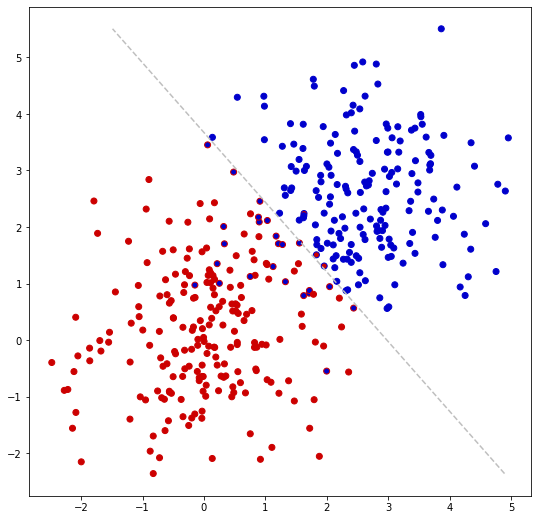

In [109]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

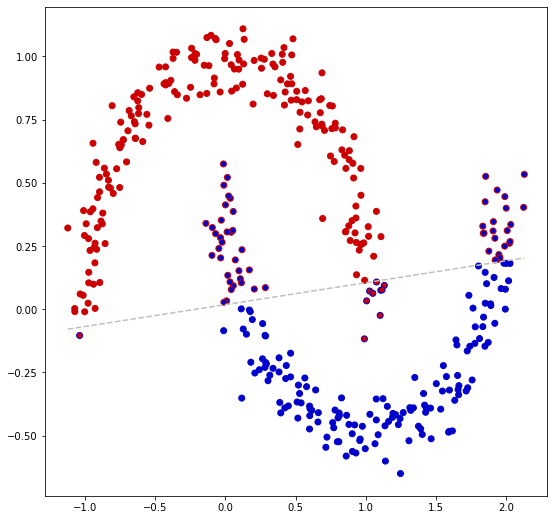

In [110]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [148]:
class PerceptronBest:
    first_class = None
    second_class = None
    
    def __init__(self, iterations: int = 100):
        self.w = None
        self.iterations = iterations
    
    def __predict__(self, x):
        return 1 if (self.w.T @ x) >= 0 else -1
    
    def __calc__accuracy__(self, X, y):
        hit = 0
        for i in range(0, len(X)):
            if y[i] == self.__predict__(X[i]):
                hit += 1
        return hit / float(len(X))
                
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        X = add_dimension(X)
        self.w = np.random.rand(1, X.shape[1])[0]
        y_unique = np.unique(y)
        self.first_class = y_unique[0]
        self.second_class = y_unique[1]
        y = [-1 if elem == self.first_class else 1 for elem in y]
        best = (self.__calc__accuracy__(X, y), self.w)
        for i in range(0, self.iterations):
            adjustment = 0
            for j in range(0, len(X)):
                if y[j] != self.__predict__(X[j]):
                    adjustment += y[j] * X[j]
            self.w += adjustment
            new_accuracy = self.__calc__accuracy__(X, y)
            if new_accuracy > best[0]:
                best = (new_accuracy, np.copy(self.w))
        self.w = best[1]
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        X = add_dimension(X)
        result = []
        for i, x in enumerate(X):
            prediction = self.__predict__(x)
            if prediction == -1:
                result.append(self.first_class)
            else:
                result.append(self.second_class)
        return result

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

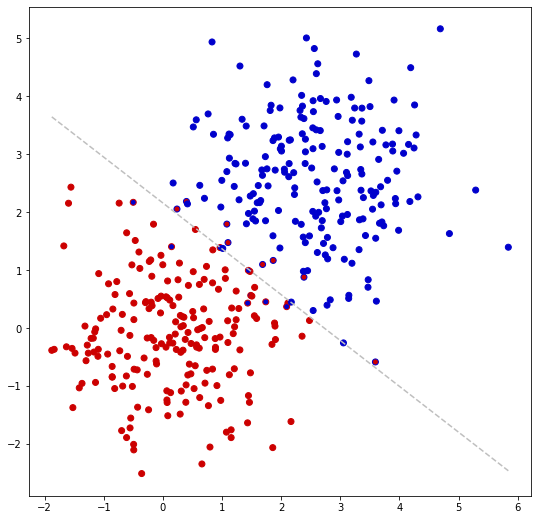

In [149]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

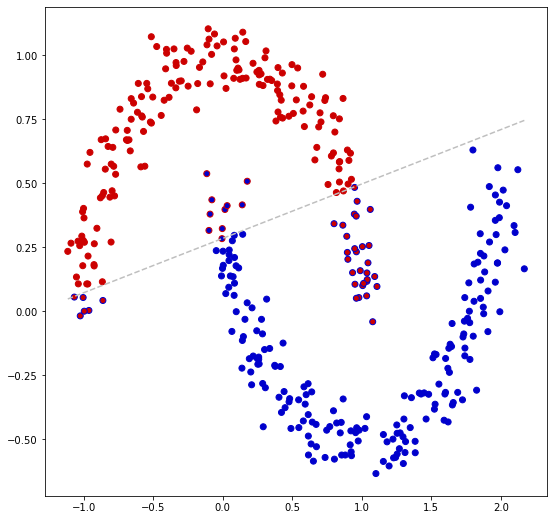

In [150]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [175]:
def transform_images(images: np.ndarray) -> np.ndarray:
    densities = []
    for i in range(0, len(images)):
        image = images[i]
        density = (0, 0)
        for h in range(0, len(image)):
            for w in range(0, len(image[h])):
                if image[h][w] != 0:
                    density = (density[0] + image[h][w], density[1] + 1)
        densities.append(density[0] / density[1]) 
    
    simmetries = []
    for i in range(0, len(images)):
        image = images[i]
        n = len(image)
        simmetry = 0
        for h in range(0, n):
            for w in range(0, n):
                simmetry += abs(image[h][w] - image[n - h - 1][w])
        simmetries.append(simmetry) 
    return np.array([[densities[i], simmetries[i]] for i in range(0, len(images))])

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [177]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

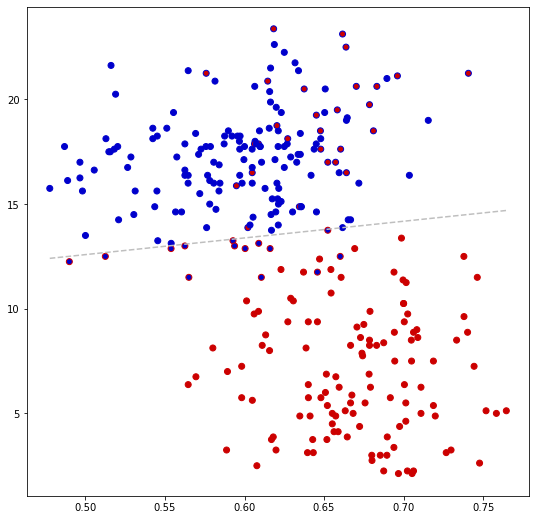

Accuracy: 0.9041095890410958


In [179]:
c = Perceptron(iterations=1000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

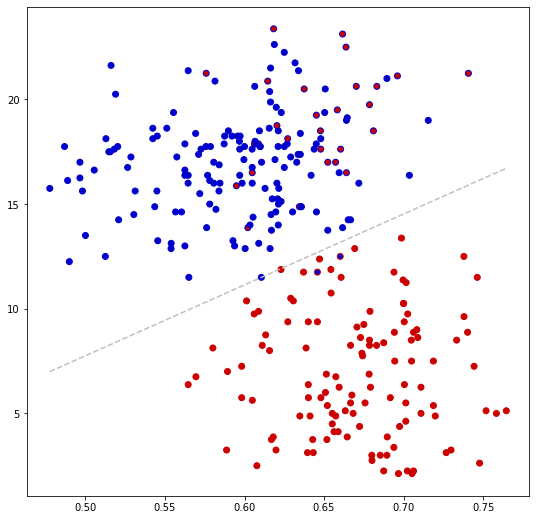

Accuracy: 0.9041095890410958


In [171]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))